# Importing all the required libraries

In [145]:
import pandas as pd
import re #RegEx for data cleaning
import html
import itertools
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
from pandas import DataFrame
# For WordCloud plot
!pip install wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import pylab as pl
from io import StringIO
from sklearn import svm

# (1) Data Cleaning
- Row data is to be cleaned before it is analyzed
- Here RegEx (Regular Expression is used for replacing some undesired things in the data such as URL and Punctuation marks.
- Initially, I used for-loop to use re command for column of tweets in the dataframe. Running a for-loop is not much efficient, so I used map function to make it more efficient.
- Also, in data_cleaning function it gived two outputs: (1) Cleaned Text and (2) The word for which tweet is posted (i.e. @virginamerica).

In [2]:
'''
(1) File will be read
    File reading can directly be done with Panda dataframe and with normal text reading commands as well.
    Here it is implemented with Pandas dataframe.
    
(2) stop_words.txt is used to eliminate the stop words.
(3) Finally the tweets whoch are empty after the cleaning ate preserved empty.
'''
# Loading the stop_word.txt file for removing the stop words
stop_words=open('stop_words.txt').read().split()
stop_words = r'\b(?:{})\b'.format('|'.join(stop_words))

def data_cleaning(filename,val):
    '''
    filename- Enter the input file which is to be cleaned.(Input- csv/txt file)
    val- You want your cleaned data without twitter handle or you want the cleaned data with twitter handle. 
    val input- Yes/yes to remove the twitter handles from the list (Please see if condition below)
    '''
    df = pd.read_csv(filename, sep=",")
    # Replacing the HTML character codes with ASCII equvivalent  
    df['text'] = df['text'].map(lambda x: html.unescape(x))
    # Removing HTML tags and attributes
    df['text'] = df['text'].map(lambda x: re.sub(r'<[^>]+>', '', x))
    # Removing URLs
    df['text'] = df['text'].map(lambda x: re.sub(r'http\S+', '', x))
    # Lowering the characters
    df['text'] = df['text'].map(lambda x: x.lower())
    # Extracting the twitter handle
    twi = df['text'].map(lambda x: re.findall('@(?=\w+)\w+',x))
    # Removing the stop words
    df['text'] = df['text'].str.replace(stop_words, '')
    # Removing the word after @
    if val.lower()=='yes':
        df['text'] = df['text'].map(lambda x: re.sub(r'@(?=\w+)\w+','',x))
    # Removing punctuations
    df['text'] = df['text'].map(lambda x: re.sub(r'[^\w\s]','',x))
    # Removing unnecessary spaces (Whitespaces) in the line
    df['text'] = df['text'].map(lambda x: x.strip())
    # Removing unnecesary non-ASCII characters from the data (i.e. ðÿ)
    def remove_non_ascii(text):
        return ''.join(i for i in text if ord(i)<128)
    df['text'] = df['text'].apply(remove_non_ascii)
    return list(df['text']), list(twi)


# (2) Exploratory Analysis
- US Airlines Tweets and Generic Tweets
- Plotting of the characterisitcs of US Airlines and Generic Tweets
- To extract the airlines name, we can not assume that airline name should occur only at the first columns so I have made the dictionary and counted the occurances for each twitter handle and dropped which was not significant.
- Hashtags were not so much important for getting the airlines names. So, # are converted into the normal word as they defines the sentiment connected with the statements.

In [3]:
cleaned_data_us,hand_us=data_cleaning('US_airline_tweets.csv','yes')
# List of list to a List (Flattening the list)
hand_us=list(set(list(itertools.chain.from_iterable(hand_us))))
#To remove @ from the twitter handle
hand_usair1=[re.sub(r'[^A-Za-z0-9]+', '', x) for x in hand_us]
hand_usair = [i for i in hand_usair1 if len(i) > 4]
hand_usair

['ferrissalameh',
 'orangecounty',
 'alynewton',
 'boeingairplanes',
 'kaps12',
 'cbssoxfan',
 'nytimes',
 'kkwhb',
 'taylorlumsden',
 'danihampton',
 'flysaa',
 'gripeo',
 'edreamsen',
 'svllindia',
 'southwestair',
 'ccicanine',
 'cheertymedad',
 'jetblue',
 'superben',
 'jayvig',
 'cltdouglas',
 'dgruber1700',
 'laurieameacham',
 'taylormdowns',
 'cosmopolitan',
 'corybronze',
 'sammijon3s',
 'jparkermastin',
 'parachuteguy',
 'virginamerica',
 'actingoutmgmnt',
 'leeannhealey',
 'theuso',
 'jmercadomma',
 'rldelahunty',
 'ejacqui',
 'nynjairports',
 '4geiger',
 'danroam',
 'mxo42',
 'upgrd',
 'burningman',
 'americanone',
 'marinadomine',
 'warriors',
 'vainglorygame',
 'kristicapel',
 'portcolumbuscmh',
 'barclaycardus',
 'jessicajaymes',
 'jameswester',
 'uschamber',
 'tatianaking',
 'jimcramer',
 'flysfo',
 'preboard',
 'bernhardtjh',
 'yaffasolin',
 'cbsphilly',
 'maxabrahms',
 'rylietolbert15',
 'tpallini',
 'datingrev',
 'tywinter',
 'flyfrontier',
 'eatgregeat',
 'keithlaw',

In [4]:
len(hand_usair)

625


## Procedure for deciding the airlines

In [5]:

df = pd.read_csv('US_airline_tweets.csv', sep=",")
df['text'] = df['text'].map(lambda x: x.lower())
df['text'] = df['text'].map(lambda x: re.sub(r'[^\w\s]','',x))
df['text'] = df['text'].str.replace(stop_words, '')

# Counting the occurances of each extraceted airline names in the Panda dataframe
count=0
freq=dict()

for j in hand_usair:
    for i in df.text:
        for l in i.split():
            for k in l.split():
                if j == k:
                    count+=1
    freq[j]=str(count)
    count=0
freq

{'ferrissalameh': '1',
 'orangecounty': '2',
 'alynewton': '1',
 'boeingairplanes': '1',
 'kaps12': '1',
 'cbssoxfan': '1',
 'nytimes': '4',
 'kkwhb': '1',
 'taylorlumsden': '1',
 'danihampton': '1',
 'flysaa': '2',
 'gripeo': '1',
 'edreamsen': '0',
 'svllindia': '1',
 'southwestair': '1778',
 'ccicanine': '1',
 'cheertymedad': '1',
 'jetblue': '1610',
 'superben': '1',
 'jayvig': '3',
 'cltdouglas': '1',
 'dgruber1700': '1',
 'laurieameacham': '1',
 'taylormdowns': '1',
 'cosmopolitan': '1',
 'corybronze': '1',
 'sammijon3s': '0',
 'jparkermastin': '1',
 'parachuteguy': '2',
 'virginamerica': '343',
 'actingoutmgmnt': '1',
 'leeannhealey': '1',
 'theuso': '0',
 'jmercadomma': '1',
 'rldelahunty': '1',
 'ejacqui': '1',
 'nynjairports': '0',
 '4geiger': '1',
 'danroam': '0',
 'mxo42': '1',
 'upgrd': '2',
 'burningman': '1',
 'americanone': '1',
 'marinadomine': '1',
 'warriors': '1',
 'vainglorygame': '1',
 'kristicapel': '0',
 'portcolumbuscmh': '2',
 'barclaycardus': '1',
 'jessicaja

In [6]:
# Removing those airlines which have very less frequency/occurance in the tweets
Final_airlines=dict((k, v) for k, v in freq.items() if int(v) >= 5)
Final_airlines

{'southwestair': '1778',
 'jetblue': '1610',
 'virginamerica': '343',
 'airlines': '127',
 'business': '101',
 'americanair': '2443',
 'flightaware': '5',
 'cowboycerrone': '7',
 'reagan': '5',
 'united': '3390',
 'unfriendly': '7',
 'gg8929': '6',
 'virginatlantic': '6',
 'americanairlines': '26',
 'airbus': '7',
 'usair': '44',
 'unitedairlines': '42',
 'imaginedragons': '17',
 'virgin': '18',
 'aircanada': '6',
 'phlairport': '17',
 'expedia': '6',
 'southwest': '76',
 'dfwairport': '12',
 'staralliance': '6',
 'usairways': '2641',
 'directtv': '6',
 'delta': '94',
 'american': '56',
 'spiritairlines': '8',
 'fortunemagazine': '10',
 'airport': '280',
 'twitter': '63'}

In [7]:
# Deleting items which can not be the airline names 
del Final_airlines['reagan'],Final_airlines['airbus'],Final_airlines['americanairlines'],Final_airlines['southwest'],Final_airlines['virgin'],Final_airlines['usair'],Final_airlines['american'],Final_airlines['cowboycerrone'],Final_airlines['phlairport'],Final_airlines['unfriendly'],Final_airlines['twitter'],Final_airlines['airlines'],Final_airlines['directtv'],Final_airlines['airport'],Final_airlines['imaginedragons'],Final_airlines['business'],Final_airlines['gg8929'],Final_airlines['expedia'],Final_airlines['flightaware'],Final_airlines['dfwairport'],Final_airlines['fortunemagazine']
Final_airlines

{'southwestair': '1778',
 'jetblue': '1610',
 'virginamerica': '343',
 'americanair': '2443',
 'united': '3390',
 'virginatlantic': '6',
 'unitedairlines': '42',
 'aircanada': '6',
 'staralliance': '6',
 'usairways': '2641',
 'delta': '94',
 'spiritairlines': '8'}

Final_airlines is the final dictionary of airlines.

## Exploratory analysis of Airlines data

In [8]:
'''
This step is to make a combined dataframe for each cleaned tweet according to the airline names- 
and to attach the sentiment with the each tweet.
'''
airline_database=pd.DataFrame(columns=['Airline','Tweet','Cletwe','Sentiment','Reason'])

airline=[]
tweet=[]
without=[]
sentiment=[]
reason=[]

for j in Final_airlines:
    for v,i in df.text.iteritems():
        if j in i:
            airline.append(j)
            tweet.append(i)
            without.append(cleaned_data_us[v])
            sentiment.append(df.sentiment[v])
            reason.append(df.negative_reason[v])
            
airline_database['Airline']=airline
airline_database['Tweet']=tweet
airline_database['Sentiment']=sentiment
airline_database['Cletwe']=without
airline_database['Reason']=reason

airline_database

,Airline,Tweet,Cletwe,Sentiment,Reason
0,southwestair,virginamerica cant supp biz traveler south...,supp biz traveler customer service nev...,negative,Customer Service Issue
1,southwestair,virginamerica love southwestair backyard ...,love backyard consumers win biz competes,positive,NaN
2,southwestair,southwestair doesnt charge ticket change fees ...,charge ticket change fees incur mysteriou...,negative,Flight Booking Problems
3,southwestair,united committed continentalairlines flye...,committed continentalairlines flyer merger r...,negative,Can't Tell
4,southwestair,united good southwestair safer sooner,good safer sooner,negative,Customer Service Issue
5,southwestair,united fly southwestair issues,fly issues,positive,NaN
6,southwestair,united suck southwestair best,suck best,positive,NaN
7,southwestair,united will americanair southwestair delta ...,will will business unfriendlyskie...,negative,Bad Flight
8,southwestair,united boarding process sucks learn southw...,boarding process sucks learn,negative,longlines
9,southwestair,united bet southwestair doesnt turn thirty m...,bet turn thirty minute delay original fli...,negative,Late Flight


After generating the whole dataframe, the next step is to observe/visualize the sentiments of each airlines with the help of a bar graph.
Note that total tweets exceeded than the original tweet dataset. It is because we assumed that two airline names may be associated with a single tweet.

In [9]:
pos_count=0
neg_count=0
analysis=dict()

for i in Final_airlines:
    for v,j in airline_database.Airline.iteritems():
        if i in j:
            if airline_database.Sentiment[v]=='positive':
                pos_count+=1
            else:
                neg_count+=1
    analysis[i]=[pos_count,neg_count]
    pos_count=0
    neg_count=0

analysis=pd.DataFrame(analysis)
analysis_end=analysis
analysis

,southwestair,jetblue,virginamerica,americanair,united,virginatlantic,unitedairlines,aircanada,staralliance,usairways,delta,spiritairlines
0,574,545,152,354,504,1,4,0,1,275,8,1
1,1209,974,190,2104,2726,4,41,6,5,2324,98,7


Text(0,0.5,'Number of Tweets')

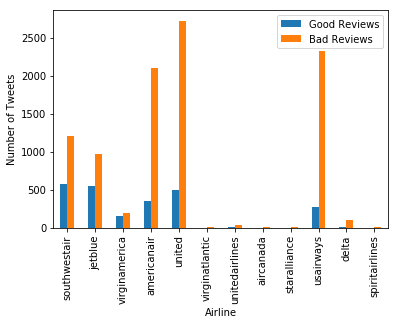

In [10]:
analysis.rename(index={0:'Good Reviews',1:'Bad Reviews'}, inplace=True)
(analysis.T).plot.bar();
plt.xlabel('Airline')  
plt.ylabel('Number of Tweets')

Grpah shown above is not unifrom so one thing can be done- Normalise the data with respect to the mean of positive tweets and mean of the negative tweets. 

Text(0,0.5,'% Tweets')

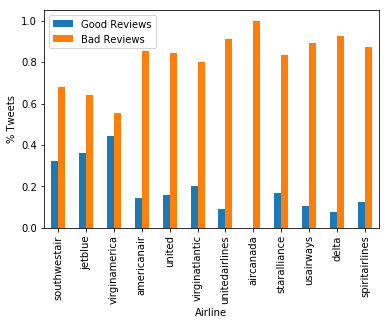

In [11]:
norm_analysis=analysis.T.div(analysis.T.sum(axis=1), axis=0)
norm_analysis.rename(index={0:'Good Reviews',1:'Bad Reviews'}, inplace=True)
(norm_analysis).plot.bar();
plt.xlabel('Airline')  
plt.ylabel('% Tweets')

### What can we say about the distribution of the airline tweets?
From the exploratory analysis-
- Mostly people tweeted for four major airlines: (1) USAirways, (2) United Airlines, (3) Americanairlines and (4) Southwest Airline
- Mostly the reviews are bad for all the airlines
- People gave the highest number of reviews on United Airlines and the highest number of negative tweets as well

## Exploratory analysis on Generic Tweets data

In [12]:
gen = pd.read_csv('generic_tweets.txt', sep=",")
cleaned_data_generic,hand_generic = data_cleaning('generic_tweets.txt','yes')
generic_database = pd.DataFrame(columns = ['Tweet_gen','Sentiment_gen'])
generic_database.Tweet_gen = cleaned_data_generic
generic_database.Sentiment_gen = gen['class'] 
generic_database

,Tweet_gen,Sentiment_gen
0,awww bummer shoulda david carr third day,0
1,upset update facebook texting cry re...,0
2,dived times ball managed save 50 rest ...,0
3,body feels itchy fire,0
4,behaving mad,0
5,crew,0
6,hug,0
7,hey long time rains bit bit lol fine,0
8,nope,0
9,muera,0


In [13]:
# Number of Positive emotions and Number of Negative emotions are same for the generic training data
(generic_database.Sentiment_gen).sum(axis=0)/4

100000.0

Training data should have almost equal variations each class then it can predict good results. Otherwise it can result in some BIAS.

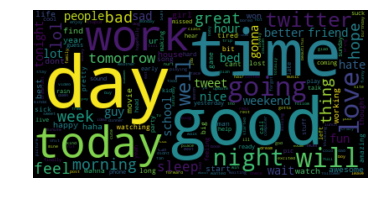

In [14]:
# Word cloud
text_cloud = generic_database.Tweet_gen
text_cloud = ''.join([w for w in text_cloud])
wordcloud = WordCloud().generate(text_cloud)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

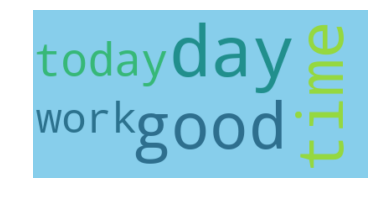

In [15]:
# Five most frequent word in the list
wordcloud = WordCloud(max_words=5,background_color="skyblue").generate(text_cloud)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

- From the exploratory analysis (word cloud graph) of the generic_tweets data, we can come up with the most frequent words and observe the pattern of the sentiment associated to that word 
- We can explore about the Infromation Gain (Split criteria for Decision Tree) of the all most frequent word in the image (Below is the analysis)

In [16]:
wordcloud.words_

{'day': 1.0,
 'good': 0.8052155401809473,
 'time': 0.7892496008515167,
 'today': 0.7706226716338478,
 'work': 0.7629945006208977}

In [17]:
#Total number of occurance of word
t = generic_database.loc[generic_database['Tweet_gen'].str.contains(' body ')]
t.groupby('Sentiment_gen').count()

,Tweet_gen
Sentiment_gen,
0,159
4,90


# (3) Model Preparation
Main dataframes from the previous parts: (1) generic_database and (2) airline_database.
- Random shuffle into Train (70%) and Test (30%) dataset
- Data should be tokenized before splitting it into Training and Testing datasets. It is because to keep the number of features same.

In order to maintain the same nuber of features, we need to combine tweets from both the datasets. Thus, it will have same features when we vectorized both the dataset of tweets. 

In [18]:
vec = CountVectorizer()
#vec_gen = vec.fit_transform(generic_database.Tweet_gen)
#vec_gen
vec_genfit = vec.fit(generic_database.Tweet_gen)
vec_gen = vec_genfit.transform(generic_database.Tweet_gen)
vec_gen

<200000x86494 sparse matrix of type '<class 'numpy.int64'>'
	with 1029731 stored elements in Compressed Sparse Row format>

Features number

In [19]:
len(vec.get_feature_names())

86494

Name of features and its indices

In [20]:
vec.vocabulary_

{'awww': 8073,
 'bummer': 13458,
 'shoulda': 67514,
 'david': 20760,
 'carr': 14747,
 'third': 75321,
 'day': 20806,
 'upset': 80081,
 'update': 79999,
 'facebook': 27192,
 'texting': 74825,
 'cry': 19717,
 'result': 63015,
 'school': 65572,
 'today': 76308,
 'blah': 10993,
 'dived': 22922,
 'times': 75873,
 'ball': 8726,
 'managed': 46781,
 'save': 65270,
 '50': 2276,
 'rest': 62955,
 'bounds': 12193,
 'body': 11582,
 'feels': 27987,
 'itchy': 39653,
 'fire': 28563,
 'behaving': 9861,
 'mad': 46333,
 'crew': 19462,
 'hug': 37178,
 'hey': 35648,
 'long': 45231,
 'time': 75818,
 'rains': 61236,
 'bit': 10804,
 'lol': 45080,
 'fine': 28475,
 'nope': 53206,
 'muera': 50745,
 'spring': 70704,
 'break': 12520,
 'plain': 58019,
 'city': 16678,
 'snowing': 69361,
 'pierced': 57628,
 'ears': 24558,
 'couldn': 18975,
 'bear': 9498,
 'watch': 82157,
 'thought': 75432,
 'ua': 79025,
 'loss': 45472,
 'embarrassing': 25343,
 'counts': 19023,
 'idk': 37844,
 'talk': 73779,
 'gun': 33626,
 'zac': 861

Extracting the labels before splitting the data

In [21]:
ylab_gen=np.array(generic_database.Sentiment_gen)
ylab_gen.shape

(200000,)

Data is shuffled while splitting

In [22]:
# Randomly spitting Train and Test dataset
x_tr_gen_1gm,x_te_gen_1gm,y_tr_gen_1gm,y_te_gen_1gm = train_test_split(vec_gen,ylab_gen,test_size=0.30,shuffle=True)
print('X Training size after splitting:{}'.format(x_tr_gen_1gm.shape))
print('X Testdata size after splitting:{}'.format(x_te_gen_1gm.shape))
print('Y Training size after splitting:{}'.format(y_tr_gen_1gm.shape))
print('Y Testdata size after splitting:{}'.format(y_te_gen_1gm.shape))

X Training size after splitting:(140000, 86494)
X Testdata size after splitting:(60000, 86494)
Y Training size after splitting:(140000,)
Y Testdata size after splitting:(60000,)


In above command for X Training size after splitting:
1,40,000 are the number of samples. 69,168 are the total number of features (Unique words, data is tokenized). 

## 2-Gram model 

In [23]:
vec_2gm = CountVectorizer(ngram_range=(1, 2))
vec_gen2gm = vec_2gm.fit_transform(generic_database.Tweet_gen)
vec_gen2gm

<200000x700928 sparse matrix of type '<class 'numpy.int64'>'
	with 1882689 stored elements in Compressed Sparse Row format>

In [24]:
# Randomly spitting Train and Test dataset
x_tr_gen_2gm,x_te_gen_2gm,y_tr_gen_2gm,y_te_gen_2gm = train_test_split(vec_gen2gm,ylab_gen,test_size=0.30,shuffle=True)
print('X Training size after splitting:{}'.format(x_tr_gen_2gm.shape))
print('X Testdata size after splitting:{}'.format(x_te_gen_2gm.shape))
print('Y Training size after splitting:{}'.format(y_tr_gen_2gm.shape))
print('Y Testdata size after splitting:{}'.format(y_te_gen_2gm.shape))

X Training size after splitting:(140000, 700928)
X Testdata size after splitting:(60000, 700928)
Y Training size after splitting:(140000,)
Y Testdata size after splitting:(60000,)


- Number of features became more than 1-gram model and it is because 2-Gram model takes a single word and a colletion of 2 words as features.
- We will continue with the 1-Gram model in the next step but 2-Gram model has its own advantages as well- because some words better describe sentiment/feeling when they are combines. For instance, (love)- is a positive word but when it is like (dont love)- it generates negative feeling. 
- Also, one thing can be observed is that in 2-Gram model number of samples are lesser than number of features. While in 1-Gram model number of samples are more than number of number of features. We can actually use both the modes to see the bias-variance trade off and can plot the graph on 1-gram model and 2-Gram model. (At last it will be tested)

# (4) Model Implementation
First model is implemented on Generic Tweet 

(1) 1-Gram model implementation
(2) L2 regularization for penalizing the model

In [25]:
# Fitting the Logistic Regression model with L2 regularization
logreg_l2_1gm = LogisticRegression(penalty='l2')
logreg_l2_1gm.fit(x_tr_gen_1gm,y_tr_gen_1gm)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [26]:
y_tepred_gen_l2_1gm = logreg_l2_1gm.predict(x_te_gen_1gm)
test_gen_l2_1gm = pd.DataFrame(columns=['y_test_gen_actual','y_test_gen_pred_1gm_l2'])
test_gen_l2_1gm.y_test_gen_actual = y_te_gen_1gm
test_gen_l2_1gm.y_test_gen_pred_1gm_l2 = y_tepred_gen_l2_1gm
# Printing the actual values and predicted values of sentiments
test_gen_l2_1gm

,y_test_gen_actual,y_test_gen_pred_1gm_l2
0,4,0
1,0,0
2,4,4
3,0,0
4,0,4
5,0,4
6,0,0
7,4,0
8,4,4
9,4,4


- Confusion Matrix and Accuracy over the Generic Tweets Test data (1 Gram model)

In [27]:
confusion_matrix(y_te_gen_1gm, y_tepred_gen_l2_1gm)

array([[21085,  8853],
       [ 6781, 23281]], dtype=int64)

In [28]:
accuracy_score(y_te_gen_1gm, y_tepred_gen_l2_1gm)

0.7394333333333334

- Accuracy of 73.845 percentage on Test data of Generic Tweets (1-Gram Model)

Now,
(1) 2-Gram model implementation
(2) L2 regularization for penalizing the model

In [29]:
# Fitting the Logistic Regression model with L2 regularization
logreg_l2_2gm = LogisticRegression(penalty='l2')
logreg_l2_2gm.fit(x_tr_gen_2gm,y_tr_gen_2gm)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
y_tepred_gen_l2_2gm = logreg_l2_2gm.predict(x_te_gen_2gm)
test_gen_l2_2gm = pd.DataFrame(columns=['y_test_gen_actual','y_test_gen_pred_2gm_l2'])
test_gen_l2_2gm.y_test_gen_actual = y_te_gen_2gm
test_gen_l2_2gm.y_test_gen_pred_2gm_l2 = y_tepred_gen_l2_2gm
# Printing the actual values and predicted values of sentiments
test_gen_l2_2gm

,y_test_gen_actual,y_test_gen_pred_2gm_l2
0,4,4
1,0,0
2,4,4
3,0,0
4,4,4
5,4,4
6,0,0
7,4,4
8,4,4
9,4,4


- Confusion Matrix and Accuracy over the Generic Tweets Test data (2 Gram model)

In [31]:
cm = confusion_matrix(y_te_gen_2gm, y_tepred_gen_l2_2gm)
cm

array([[21164,  9025],
       [ 6454, 23357]], dtype=int64)

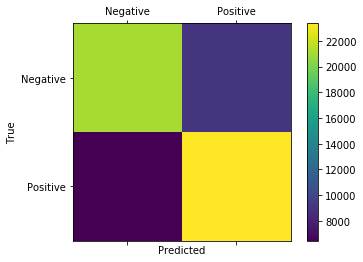

In [32]:
lab=['Negative','Positive']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
ax.set_xticklabels([''] + lab)
ax.set_yticklabels([''] + lab)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [33]:
accuracy_score(y_te_gen_2gm, y_tepred_gen_l2_2gm)

0.7420166666666667

- Accuracy of 74.153 percentage on Test data of Generic Tweets (2-Gram model)

## Trained model (Logistic Regression model) on generic tweet (1-gram) is applied to check the accuracy of US Airline Tweets Data

In [34]:
# Converting postive and negative word into 4 and 0 sentiment values, respectively
airline_database.Sentiment[airline_database.Sentiment == 'negative'] = 0
airline_database.Sentiment[airline_database.Sentiment == 'positive'] = 4
airline_database.Sentiment

0        0
1        4
2        0
3        0
4        0
5        4
6        4
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       4
19       4
20       0
21       0
22       4
23       0
24       4
25       0
26       4
27       4
28       0
29       0
        ..
12032    0
12033    0
12034    0
12035    0
12036    4
12037    0
12038    0
12039    0
12040    0
12041    0
12042    0
12043    0
12044    0
12045    0
12046    0
12047    0
12048    0
12049    0
12050    0
12051    0
12052    0
12053    0
12054    0
12055    0
12056    0
12057    4
12058    0
12059    0
12060    0
12061    0
Name: Sentiment, Length: 12062, dtype: object

In [35]:
airline_database

,Airline,Tweet,Cletwe,Sentiment,Reason
0,southwestair,virginamerica cant supp biz traveler south...,supp biz traveler customer service nev...,0,Customer Service Issue
1,southwestair,virginamerica love southwestair backyard ...,love backyard consumers win biz competes,4,NaN
2,southwestair,southwestair doesnt charge ticket change fees ...,charge ticket change fees incur mysteriou...,0,Flight Booking Problems
3,southwestair,united committed continentalairlines flye...,committed continentalairlines flyer merger r...,0,Can't Tell
4,southwestair,united good southwestair safer sooner,good safer sooner,0,Customer Service Issue
5,southwestair,united fly southwestair issues,fly issues,4,NaN
6,southwestair,united suck southwestair best,suck best,4,NaN
7,southwestair,united will americanair southwestair delta ...,will will business unfriendlyskie...,0,Bad Flight
8,southwestair,united boarding process sucks learn southw...,boarding process sucks learn,0,longlines
9,southwestair,united bet southwestair doesnt turn thirty m...,bet turn thirty minute delay original fli...,0,Late Flight


In [36]:
vec_us = vec_genfit.transform(airline_database.Cletwe)
vec_us

<12062x86494 sparse matrix of type '<class 'numpy.int64'>'
	with 78521 stored elements in Compressed Sparse Row format>

In [37]:
ypred_us = logreg_l2_1gm.predict(vec_us)
cm1 = confusion_matrix(list(airline_database.Sentiment),list(ypred_us))
cm1

array([[6957, 2690],
       [ 547, 1868]], dtype=int64)

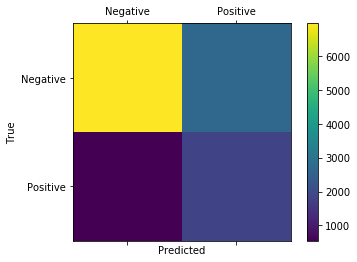

In [38]:
lab=['Negative','Positive']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm1)
fig.colorbar(cax)
ax.set_xticklabels([''] + lab)
ax.set_yticklabels([''] + lab)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [39]:
accuracy_score(list(airline_database.Sentiment), list(ypred_us))

0.7316365445199801

### What can be deduced from it?
- Accuracy of the US Airline data: Approx. 72%
- Accuracy of generic tweets data: Approx. 73%
Almost accuracy for both the datasets are same. One reason can be thought is that: generic dataset has robust word list, which can define positive and negative sentiments clearly.

### Part II: Analyzing negative sentiments for US Airline dataset

In [56]:
neg_us=pd.DataFrame(columns=['neg_tweet','reason','airline'])
neg_us.neg_tweet = airline_database.Cletwe[airline_database.Sentiment == 0]
neg_us.reason = airline_database.Reason[airline_database.Sentiment == 0]
neg_us.airline = airline_database.Airline[airline_database.Sentiment == 0]
neg_us

,neg_tweet,reason,airline
0,supp biz traveler customer service nev...,Customer Service Issue,southwestair
2,charge ticket change fees incur mysteriou...,Flight Booking Problems,southwestair
3,committed continentalairlines flyer merger r...,Can't Tell,southwestair
4,good safer sooner,Customer Service Issue,southwestair
7,will will business unfriendlyskie...,Bad Flight,southwestair
8,boarding process sucks learn,longlines,southwestair
9,bet turn thirty minute delay original fli...,Late Flight,southwestair
10,waiting hit hour,longlines,southwestair
11,happy cancelled flighted flight tomorrow ph...,Cancelled Flight,southwestair
12,hello hold extremely long time confirmati...,Customer Service Issue,southwestair


In [57]:
unique_complaints=list(set(list(neg_us.reason)))
unique_complaints

['Bad Flight',
 'Customer Service Issue',
 'Cancelled Flight',
 'Lost Luggage',
 "Can't Tell",
 'Late Flight',
 'Damaged Luggage',
 'Flight Attendant Complaints',
 'Flight Booking Problems',
 'longlines']

In [58]:
us = CountVectorizer()
us_negdata = us.fit_transform(neg_us.neg_tweet)
us_negdata

<9647x9997 sparse matrix of type '<class 'numpy.int64'>'
	with 73345 stored elements in Compressed Sparse Row format>

In [59]:
c = 1

for i in unique_complaints:
    for v,j in neg_us.reason.items():
        if i == j:
            neg_us.reason[v] = c
    c += 1

neg_resmul = np.array(neg_us.reason)
neg_resmul

array([2, 9, 5, ..., 2, 5, 3], dtype=object)

In [73]:
x_tr_us,x_te_us,y_tr_us,y_te_us = train_test_split(us_negdata,neg_resmul,test_size=0.30,shuffle=True)
print('X Training size after splitting:{}'.format(x_tr_us.shape))
print('X Testdata size after splitting:{}'.format(x_te_us.shape))
print('Y Training size after splitting:{}'.format(y_tr_us.shape))
print('Y Testdata size after splitting:{}'.format(y_te_us.shape))

X Training size after splitting:(6752, 9997)
X Testdata size after splitting:(2895, 9997)
Y Training size after splitting:(6752,)
Y Testdata size after splitting:(2895,)


In [74]:
lr = LogisticRegression().fit(x_tr_us,list(y_tr_us))
y_pred_us = lr.predict(x_te_us)

In [75]:
y_pred_us

array([ 3,  6, 10, ...,  2,  2,  1])

In [76]:
cm2 = confusion_matrix(list(y_te_us),list(y_pred_us))
cm2

array([[ 57,  33,   2,   3,  38,  33,   0,   6,   1,   2],
       [  8, 680,  28,  10,  71,  37,   1,  18,  27,   1],
       [  3,  32, 211,   4,  11,  19,   0,   3,   3,   0],
       [  1,  32,   3, 150,  20,  13,   0,   4,   1,   1],
       [ 15, 104,   9,   8, 221,  32,   0,   7,   9,   0],
       [  6,  68,  11,   9,  44, 375,   0,   5,   1,   3],
       [  0,   2,   0,   9,   5,   3,   4,   1,   0,   0],
       [ 11,  57,   3,   6,  12,  16,   0,  51,   2,   0],
       [  7,  64,  11,   2,  21,   5,   0,   1,  53,   0],
       [  0,  20,   0,   5,   9,   9,   0,   2,   2,   8]], dtype=int64)

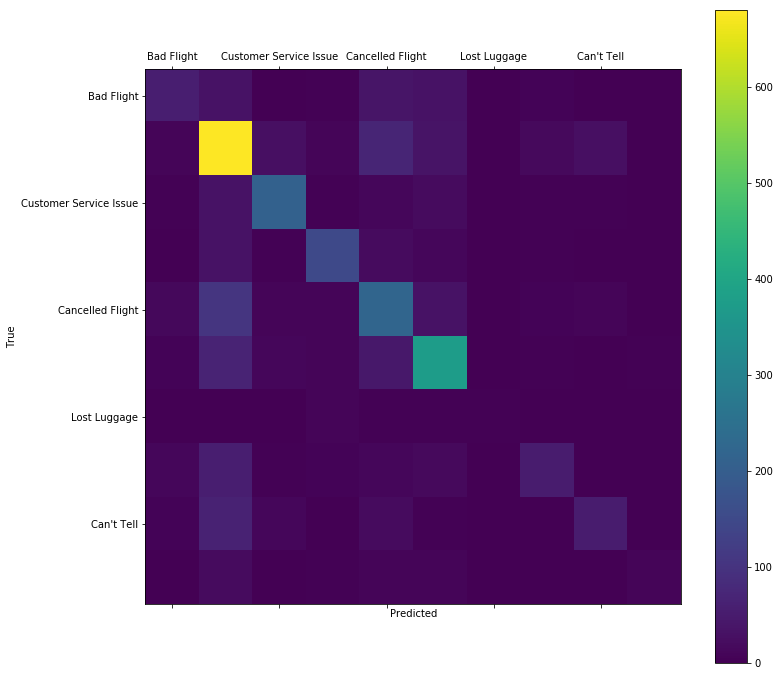

In [77]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cax = ax.matshow(cm2)
fig.colorbar(cax)
ax.set_xticklabels([''] + unique_complaints)
ax.set_yticklabels([''] + unique_complaints)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [78]:
accuracy_score(list(y_te_us),list(y_pred_us))

0.6252158894645942

# (5) Discussion: 

(Some of the analytical details may repeat here from the above section, please note that it is operated sequentially)

# What can public opinion on Twitter tell us about the US airlines in 2015?

### (I) From the first model (trained on generic tweets data and tested on us airlines) :

- Accuracy remained almost same, eventhough it was trained completely on the different model. Two major reasons can be deduced from that: (1) Generic data covered almost major negative and postive sentiment words, which are there in the US Airlines data and (2) Accuracy can be increased by training the logistic regression model on US Airline data rather than Generic tweets data.
- 2-Gram model gives slight higher accuracy than 1-Gram model. Number of features increased in 2-Gram model. It is because it considers 1 and 2 words as a bag-of-words.

### (II) How each airline is viewed in the public eyes? (Please See below for analytical details)
- Most negative sentiments were found for United Airlines and then for US Airways
- There were almst mixed reviews for Jet blue and Virgin America Airlines
- From the confusion matrix it can be seen that most of the negative sentiments were associated with Customer Service Issues. So, it can be said that this issue remains common for almost all the air lines. Customere service issues can be given the highest priority for improvement.

In [50]:
analysis_end

,southwestair,jetblue,virginamerica,americanair,united,virginatlantic,unitedairlines,aircanada,staralliance,usairways,delta,spiritairlines
Good Reviews,574,545,152,354,504,1,4,0,1,275,8,1
Bad Reviews,1209,974,190,2104,2726,4,41,6,5,2324,98,7


In [51]:
unique_complaints=list(set(list(neg_us.reason)))
unique_complaints

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [52]:
cm2 = confusion_matrix(list(y_te_us),list(y_pred_us))
cm2

array([[ 58,  32,   2,   5,  37,  24,   0,   8,   2,   2],
       [  9, 707,  22,  17,  83,  34,   0,  23,  36,   2],
       [  1,  31, 188,   5,  12,  26,   0,   3,  10,   0],
       [  0,  25,   0, 163,  22,  14,   0,   2,   2,   0],
       [ 10,  86,   7,  11, 218,  17,   0,   6,  10,   0],
       [ 11,  56,  12,  10,  49, 387,   0,   6,   2,   1],
       [  0,   3,   0,  16,   6,   0,   1,   0,   0,   0],
       [ 11,  39,   1,   7,  20,   9,   0,  57,   0,   2],
       [  3,  45,  12,   2,  32,  10,   0,   3,  60,   0],
       [  0,  16,   1,   4,   4,  16,   0,   4,   2,   3]], dtype=int64)

### (III) What else can we do for the highest negative sentiment (i.e. Customere Service Issue)?

- It is obvious that not all the airline have customere service issues. All the airline can be extracted for customere service issue sentiment. It is shown below:

In [53]:
# Database for the negative sentiments only
neg_us=pd.DataFrame(columns=['neg_tweet','reason','airline'])
neg_us.neg_tweet = airline_database.Cletwe[airline_database.Sentiment == 0]
neg_us.reason = airline_database.Reason[airline_database.Sentiment == 0]
neg_us.airline = airline_database.Airline[airline_database.Sentiment == 0]
neg_us

,neg_tweet,reason,airline
0,supp biz traveler customer service nev...,Customer Service Issue,southwestair
2,charge ticket change fees incur mysteriou...,Flight Booking Problems,southwestair
3,committed continentalairlines flyer merger r...,Can't Tell,southwestair
4,good safer sooner,Customer Service Issue,southwestair
7,will will business unfriendlyskie...,Bad Flight,southwestair
8,boarding process sucks learn,longlines,southwestair
9,bet turn thirty minute delay original fli...,Late Flight,southwestair
10,waiting hit hour,longlines,southwestair
11,happy cancelled flighted flight tomorrow ph...,Cancelled Flight,southwestair
12,hello hold extremely long time confirmati...,Customer Service Issue,southwestair


In [54]:
# Now to fetch the airline which has most frequent customere service issue
name_air = set(list(neg_us.airline))
airline_rea=dict()
count = 0

#for k in unique_complaints:
for i in name_air:
    for v,j in neg_us.airline.items():
        if j == i:
            if 'Customer Service Issue' == str(neg_us.reason[v]):
                count += 1
    airline_rea[i] = [count]
    count = 0

airline_rea

{'southwestair': [397],
 'jetblue': [203],
 'united': [696],
 'virginamerica': [62],
 'americanair': [814],
 'unitedairlines': [13],
 'virginatlantic': [1],
 'aircanada': [1],
 'delta': [21],
 'spiritairlines': [4],
 'staralliance': [2],
 'usairways': [835]}

From above: the conclusion can be drawn-
##### Conclusion: US Airways and American Air should more focus on Customer Service Issues 

### (IV) Why model failed to predict correct reason?
- Above in this section 5, a confusion matrix is shown for one-vs-all logistic regression model. It can be seen that majorly, it mis-classified true Customere Services Issue negative sentiment as Can't Tell negative sentiment. This can happen when two conditions are extremly similar. 
- Also Confusion matrix shows that major wrong predicitons were counted as Can't tell negative sentiment. Can't tell can be removed, as it does not give much infromation.

### (V) What can be done to improve the efficiency?
- For both the models: we can adopt k-fold or cross validation to tune the hyper-parameter, instead of just splitting it into train and test data.
- For the second model (US Negative Tweets): We can drop some negative reasons which have no meaning (such as Cant tell) and combine those words which have almost similar meaning (e.g., Cancelled flight and Late flight) or reasons are related to certain part of the airlines only (e.g., Damaged luggage and Lost luggage are managed by the same department i.e. luggage department. So these reason can be combined and the class labels can also be reduced). 


### (VI) Can we combined the similar negative reasons or the reasons which are associated to the same staff of the airlines? (Explained just above) How much the accuracy will be improved?

In [131]:
'''
New model preparation

(1) Negative reason Can't tell is ignored becuase anyways, we cannot deduce anything from it.

Now the rest of the complaints are subdivided into 4 major staff of the Airlines:

(2) Customer Relations: Combined 'Customer Service Issue', 'Flight Booking Complaints', and 'Longlines'
(3) Flight Technical: Combined 'Late Flight' and 'Cancelled Flight'
(4) Luggage Handling: Combined 'Lost luggage' and 'Damaged Luggage'
(5) Flight Crew: Combined 'Bad Flight' and 'Flight Attendent Complaints'

So New Model will have only four classes instead of 10 different classes. Loss should reduce now.
'''
# Recalling the database for the negative sentiments only
neg_us=pd.DataFrame(columns=['neg_tweet','reason','airline'])
neg_us.neg_tweet = airline_database.Cletwe[airline_database.Sentiment == 0]
neg_us.reason = airline_database.Reason[airline_database.Sentiment == 0]
neg_us.airline = airline_database.Airline[airline_database.Sentiment == 0]

comp4=['Customer Service Issue','Flight Booking Problems','longlines'],['Late Flight','Cancelled Flight'],['Lost Luggage','Damaged Luggage'],['Bad Flight','Flight Attendant Complaints']

neg_us_4=neg_us

neg_us_4.reason[neg_us_4.reason == 'Customer Service Issue'] = 0
neg_us_4.reason[neg_us_4.reason == 'Flight Booking Problems'] = 0
neg_us_4.reason[neg_us_4.reason == 'longlines'] = 0

neg_us_4.reason[neg_us_4.reason == 'Late Flight'] = 1
neg_us_4.reason[neg_us_4.reason == 'Cancelled Flight'] = 1

neg_us_4.reason[neg_us_4.reason == 'Lost Luggage'] = 2
neg_us_4.reason[neg_us_4.reason == 'Damaged Luggage'] = 2

neg_us_4.reason[neg_us_4.reason == 'Bad Flight'] = 3
neg_us_4.reason[neg_us_4.reason == 'Flight Attendant Complaints'] = 3

exclusion = "Can't Tell" 
neg_us_4_ex = neg_us_4[neg_us_4.reason != exclusion]
neg_us_4_ex


,neg_tweet,reason,airline
0,supp biz traveler customer service nev...,0,southwestair
2,charge ticket change fees incur mysteriou...,0,southwestair
4,good safer sooner,0,southwestair
7,will will business unfriendlyskie...,3,southwestair
8,boarding process sucks learn,0,southwestair
9,bet turn thirty minute delay original fli...,1,southwestair
10,waiting hit hour,0,southwestair
11,happy cancelled flighted flight tomorrow ph...,1,southwestair
12,hello hold extremely long time confirmati...,0,southwestair
13,frustrated loooooong wait time speak live...,0,southwestair


In [135]:
us_4 = CountVectorizer()
us_negdata4 = us_4.fit_transform(neg_us_4_ex.neg_tweet)
us_negdata4

<8355x9149 sparse matrix of type '<class 'numpy.int64'>'
	with 65513 stored elements in Compressed Sparse Row format>

In [157]:
x_tr_us4,x_te_us4,y_tr_us4,y_te_us4 = train_test_split(us_negdata4,np.array(neg_us_4_ex.reason),test_size=0.30,shuffle=True)
print('X Training size after splitting:{}'.format(x_tr_us4.shape))
print('X Testdata size after splitting:{}'.format(x_te_us4.shape))
print('Y Training size after splitting:{}'.format(y_tr_us4.shape))
print('Y Testdata size after splitting:{}'.format(y_te_us4.shape))

X Training size after splitting:(5848, 9149)
X Testdata size after splitting:(2507, 9149)
Y Training size after splitting:(5848,)
Y Testdata size after splitting:(2507,)


In [158]:
lr4 = LogisticRegression().fit(x_tr_us4,list(y_tr_us4))
y_pred_us4 = lr4.predict(x_te_us4)

In [159]:
accuracy_score(list(y_te_us4),list(y_pred_us4))

0.7538891104906262

### When we reduced number of labels/combined similar labels and assign same values to them, the accuracy of the model significantly increased by almost 10%. Although the data is randomly shuffled so it may vary. 

# Extra work: 

(*) Decision Tree (Training: Generic Tweets, Testing: Generic Tweets, Model Specification: 1-Gram model)
- Decision tree will give very bad results/predictions. It is becuase the algorithm works on the Split Criteria of a word in the dataset. A word may have the highest frequency in the dataset but the important thing is: how many positive sentiment training data contains it? and how many negative sentiment training data contains it? ----- This answers introduce Infromation Gain on which whole Decision Tree is being split. If the word which has the highest frequency in the training data but the label for that word is 50% Positive and 50% Negative then it will have highest Entropy and so that word has the lowest Information Gain and the tree can not be splitted on it.

In [143]:
# Accuracy on Generic tweet 1-gram model
clf = DecisionTreeClassifier().fit(x_tr_gen_1gm,y_tr_gen_1gm)
y_tree_pred=clf.predict(x_te_gen_1gm)
# Accuracy from Decision Tree algorithm
accuracy_score(y_te_gen_1gm, y_tree_pred)

KeyboardInterrupt: 